## Data Source:
https://www.kaggle.com/datasets/boltzmannbrain/nab/data

## Research and References

1. SageMaker RCF documentation
  - https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html
  - https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.html 

2. S3
  - https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-download-file.html
  
3. matplotlib
  - https://stackoverflow.com/questions/12998430/how-to-remove-xticks-from-a-plot
  
## Notes:
Univariate time series, Minnesota Taxi



In [2]:
# Import libraries

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import RandomCutForest
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
# Load data from S3:

sm = sagemaker.Session()

bucket = sm.default_bucket()
prefix = 'numenta_anomaly_benchmark'
key = "realTraffic"
filename = 'occupancy_t4013.csv'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [8]:
bucket

'sagemaker-us-east-1-650363544726'

In [12]:
# Download raw data from s3 bucket
s3 = boto3.client("s3")
s3.download_file(bucket, f"{prefix}/{key}/{filename}", f"./data/{filename}")

In [13]:
taxi_df = pd.read_csv(f"./data/{filename}", delimiter=",")


In [14]:
taxi_df.head()

,timestamp,value
0,2015-09-01 11:30:00,13.56
1,2015-09-01 11:35:00,8.33
2,2015-09-01 11:40:00,11.78
3,2015-09-01 11:55:00,15.28
4,2015-09-01 12:00:00,10.06


In [15]:
taxi_df['value'].describe()

count    2500.000000
mean        7.242640
std         4.372321
min         0.000000
25%         4.060000
50%         6.830000
75%         9.830000
max        43.060000
Name: value, dtype: float64

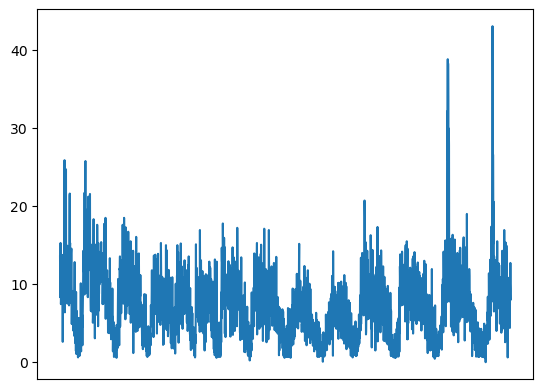

In [16]:
plt.plot(taxi_df['timestamp'] , taxi_df['value'])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [17]:
taxi_df['value'].to_numpy().reshape(-1, 1)

array([[13.56],
       [ 8.33],
       [11.78],
       ...,
       [10.  ],
       [ 9.39],
       [ 8.06]])

In [18]:
## Create Estimaator

rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Train Estimator

In [19]:
# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_df['value'].to_numpy().reshape(-1, 1)))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2024-02-26-21-11-34-604


2024-02-26 21:11:34 Starting - Starting the training job...
2024-02-26 21:12:01 Starting - Preparing the instances for training......
2024-02-26 21:12:56 Downloading - Downloading input data...
2024-02-26 21:13:21 Downloading - Downloading the training image.........
2024-02-26 21:14:42 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[02/26/2024 21:15:05 INFO 139791118272320] Reading default configuration

Run Inferences

In [20]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2024-02-26-21-15-49-498
INFO:sagemaker:Creating endpoint-config with name randomcutforest-2024-02-26-21-15-49-498
INFO:sagemaker:Creating endpoint with name randomcutforest-2024-02-26-21-15-49-498


-------!

In [21]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()



In [22]:
taxi_data_numpy = taxi_df['value'].to_numpy().reshape(-1, 1)
print(taxi_data_numpy[:6])

results = rcf_inference.predict(
    taxi_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[13.56]
 [ 8.33]
 [11.78]
 [15.28]
 [10.06]
 [ 7.44]]


In [23]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
taxi_df["score"] = pd.Series(scores, index=taxi_df.index)
taxi_df.head()

,timestamp,value,score
0,2015-09-01 11:30:00,13.56,1.685649
1,2015-09-01 11:35:00,8.33,0.953084
2,2015-09-01 11:40:00,11.78,1.381407
3,2015-09-01 11:55:00,15.28,2.062399
4,2015-09-01 12:00:00,10.06,1.242723


In [38]:
score_mean = taxi_df["score"].mean()
score_std = taxi_df["score"].std()
score_cutoff = score_mean + 3 * score_std

anomalies = taxi_data_subset[taxi_data_subset["score"] > score_cutoff]
anomalies

,timestamp,value,score
25,2015-09-01 14:10:00,25.89,3.690504
33,2015-09-01 15:05:00,24.72,3.618904
53,2015-09-01 17:15:00,21.33,3.264054
54,2015-09-01 17:20:00,21.61,3.309555
136,2015-09-02 06:45:00,21.72,3.324261
140,2015-09-02 07:05:00,25.61,3.677931
141,2015-09-02 07:10:00,25.78,3.690355
151,2015-09-02 08:00:00,19.56,2.996616
152,2015-09-02 08:05:00,18.00,2.682506
157,2015-09-02 08:30:00,21.22,3.256649


Text(0.5, 1.0, 'Minesota Taxi Occupancy')

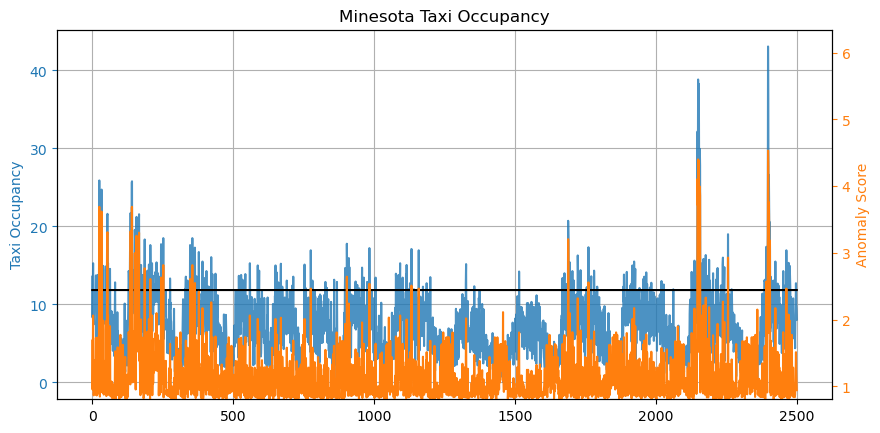

In [47]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_df)

taxi_data_subset = taxi_df[start:end]

ax2.plot([score_cutoff]*len(taxi_df), color = 'black')

ax1.plot(taxi_data_subset["value"], color="C0", alpha=0.8)
ax2.plot(taxi_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Taxi Occupancy", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")



#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)
ax1.set_title('Minnesota Taxi Occupancy')

,timestamp,value,score
25,2015-09-01 14:10:00,25.89,3.690504
33,2015-09-01 15:05:00,24.72,3.618904
53,2015-09-01 17:15:00,21.33,3.264054
54,2015-09-01 17:20:00,21.61,3.309555
136,2015-09-02 06:45:00,21.72,3.324261
140,2015-09-02 07:05:00,25.61,3.677931
141,2015-09-02 07:10:00,25.78,3.690355
151,2015-09-02 08:00:00,19.56,2.996616
152,2015-09-02 08:05:00,18.00,2.682506
157,2015-09-02 08:30:00,21.22,3.256649


# Delete Endpoint

In [55]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: randomcutforest-2024-02-25-05-17-27-560
